In [153]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [154]:
chowdeck = "C:/Users/Jedda/OneDrive/Desktop/Food Recommender/chowdeck_menus.csv" 
scraped_restaurants = "C:/Users/Jedda/OneDrive/Desktop/Food Recommender/DATA/ghana_restaurant_menus.csv"
manual_restaurants = "C:/Users/Jedda/OneDrive/Desktop/Food Recommender/DATA/manual_restaurant_menus.csv"


In [155]:
chowdeck_df = pd.read_csv(chowdeck)
scraped_df = pd.read_csv(scraped_restaurants)
manual_df = pd.read_csv(manual_restaurants)

In [156]:

# --- Clean Chowdeck dataset only ---
chowdeck_clean = chowdeck_df.copy()

# Standardize price
chowdeck_clean['price'] = pd.to_numeric(chowdeck_clean['price'], errors='coerce')

# Standardize taste ratings (if they exist, keep as numeric)
chowdeck_clean['taste'] = pd.to_numeric(chowdeck_clean['taste'], errors='coerce')

# Add missing columns to match master schema
chowdeck_clean['description'] = np.nan
chowdeck_clean['source_url'] = "chowdeck"

# Reorder to master schema
target_cols = [
    "restaurant","food","price","taste","location",
    "portion_size","dish_category","description","source_url"
]
chowdeck_clean = chowdeck_clean[target_cols]

chowdeck_clean.tail()

,restaurant,food,price,taste,location,portion_size,dish_category,description,source_url
2021,Garden District Kitchen,1 Plate of Oha Soup,105.0,6.9,Accra,NaN,A PLATE OF SOUPS ONLY,NaN,chowdeck
2022,Garden District Kitchen,1 Plate of Ogbono Soup,95.0,3.9,Accra,NaN,A PLATE OF SOUPS ONLY,NaN,chowdeck
2023,Garden District Kitchen,1 Plate of Okro Soup,95.0,7.7,Accra,NaN,A PLATE OF SOUPS ONLY,NaN,chowdeck
2024,Garden District Kitchen,1 Plate of Egusi Soup,95.0,8.2,Accra,NaN,A PLATE OF SOUPS ONLY,NaN,chowdeck
2025,Garden District Kitchen,Rice and Stew Assorted,90.0,9.1,Accra,NaN,RICE,NaN,chowdeck


In [157]:

from rapidfuzz import process

def recommend_dish_fuzzy(dish_name, df, top_k=5, cheap_bias=0.5, cutoff=70):
    """
    dish_name  : Query string (e.g., 'waaky3')
    df         : DataFrame with normalized price/taste
    top_k      : How many options to return
    cheap_bias : 1.0 = prioritize cheap, 0.0 = prioritize taste
    cutoff     : Minimum fuzzy string similarity (0–100)
    """
    # Get all unique dishes
    unique_dishes = df['food'].dropna().unique().tolist()
    
    # Try to find the closest fuzzy match
    result = process.extractOne(dish_name, unique_dishes, score_cutoff=cutoff)
    
    if result is None:
        return f"No matches found for '{dish_name}'"
    
    match, similarity = result
    print(f"🔎 Input '{dish_name}' matched to '{match}' (similarity {similarity})")
    
    # Filter by the chosen match
    subset = df[df['food'].str.contains(match, case=False, na=False)].copy()
    
    if subset.empty:
        return f"No rows found matching '{match}' in dataset"
    
    # Weighted score: price vs taste
    subset.loc[:, 'score'] = cheap_bias*subset['price_norm'] + (1 - cheap_bias)*subset['taste_norm']
    
    return subset.sort_values('score', ascending=False).head(top_k)[
        ['restaurant', 'food', 'price', 'taste', 'location', 
         'portion_size', 'dish_category', 'score']
    ]


In [158]:

from rapidfuzz import process

def recommend_dish_fuzzy(dish_name, df, top_k=5, cheap_bias=0.5, cutoff=70):
    """
    dish_name  : Query string (e.g., 'waaky3')
    df         : DataFrame with normalized price/taste
    top_k      : How many options to return
    cheap_bias : 1.0 = prioritize cheap, 0.0 = prioritize taste
    cutoff     : Minimum fuzzy string similarity (0–100)
    """
    # Get all unique dishes
    unique_dishes = df['food'].dropna().unique().tolist()
    
    # Try to find the closest fuzzy match
    result = process.extractOne(dish_name, unique_dishes, score_cutoff=cutoff)
    
    if result is None:
        return f"No matches found for '{dish_name}'"
    
    match, similarity = result
    print(f"🔎 Input '{dish_name}' matched to '{match}' (similarity {similarity})")
    
    # Filter by the chosen match
    subset = df[df['food'].str.contains(match, case=False, na=False)].copy()
    
    if subset.empty:
        return f"No rows found matching '{match}' in dataset"
    
    # Weighted score: price vs taste
    subset.loc[:, 'score'] = cheap_bias*subset['price_norm'] + (1 - cheap_bias)*subset['taste_norm']
    
    return subset.sort_values('score', ascending=False).head(top_k)[
        ['restaurant', 'food', 'price', 'taste', 'location', 
         'portion_size', 'dish_category', 'score']
    ]


In [159]:
# --- Clean Manual dataset only ---
manual_clean = manual_df.copy()

# Normalize text casing & strip whitespace
manual_clean["food"] = manual_clean["food"].astype(str).str.strip().str.title()
manual_clean["dish_category"] = manual_clean["dish_category"].astype(str).str.strip().str.title()

# Normalize price (remove GH₵ signs, ranges kept as string for now)
def clean_price(p):
    if pd.isna(p):
        return None
    p_str = str(p).replace("₵","").replace("GH₵","").replace("Gh¢","").strip()
    if "-" in p_str:
        try:
            lo, hi = p_str.split("-")
            return (float(lo) + float(hi)) / 2
        except:
            return None
    try:
        return float(p_str)
    except:
        return None

manual_clean["price"] = manual_clean["price"].apply(clean_price)



# Add source_url column
manual_clean["source_url"] = "manual_entry"

# Reorder to match our target schema
manual_clean = manual_clean[[
    "restaurant","food","price","taste","location","portion_size","dish_category","description","source_url"
]]

manual_clean.head()

,restaurant,food,price,taste,location,portion_size,dish_category,description,source_url
0,DNR,Chicken Salad,30.0,NaN,East Legon,NaN,Salads,"Chicken, lettuce, onion, tomato, cucumber, pic...",manual_entry
1,DNR,Egg Salad,30.0,NaN,East Legon,NaN,Salads,"Egg, lettuce, onion, tomato, lemon and red pepper",manual_entry
2,DNR,Turkish Salad,30.0,NaN,East Legon,NaN,Salads,"Tomato, green pepper, cucumber, onion and lemon",manual_entry
3,DNR,Potato Salad,30.0,NaN,East Legon,NaN,Salads,"Potato, lettuce, onion, tomato and lemon",manual_entry
4,DNR,Fish Salad,30.0,NaN,East Legon,NaN,Salads,"Fish, cucumber, lettuce, onion, tomato, pickle...",manual_entry


In [160]:
# Align scraped_df columns with master schema
target_cols = ["restaurant","food","price","taste","location",
               "portion_size","dish_category","description","source_url"]

for col in target_cols:
    if col not in scraped_df.columns:
        scraped_df[col] = None  # fill missing with None

scraped_clean = scraped_df[target_cols].copy()

scraped_clean.head()

,restaurant,food,price,taste,location,portion_size,dish_category,description,source_url
0,Buka,Asun (Peppered Goat),100,NaN,Accra,NaN,Uncategorized,"A spicy and smoky dish of chopped goat meat, s...",https://wirecake.com/buka-restaurant-menu-prices/
1,Buka,Peppered Snails,125,NaN,Accra,NaN,Uncategorized,A true delicacy for the adventurous palate.,https://wirecake.com/buka-restaurant-menu-prices/
2,Buka,Suya,90,NaN,Accra,NaN,Uncategorized,Classic Nigerian grilled meat skewers with a s...,https://wirecake.com/buka-restaurant-menu-prices/
3,Buka,Peppered Octopus,85,NaN,Accra,NaN,Uncategorized,Tender octopus in a vibrant pepper sauce.,https://wirecake.com/buka-restaurant-menu-prices/
4,Buka,Peppered Gizzards,65,NaN,Accra,NaN,Uncategorized,A delicious and savory bite.,https://wirecake.com/buka-restaurant-menu-prices/


In [161]:
for df in [chowdeck_clean, manual_clean, scraped_clean]:
    if "votes_count" not in df.columns:
        df["votes_count"] = 1

In [162]:


# Concatenate them into one master DataFrame
combined_df = pd.concat([chowdeck_clean[target_cols+["votes_count"]],
                         manual_clean[target_cols+["votes_count"]],
                         scraped_clean[target_cols+["votes_count"]]],
                        ignore_index=True)

# Optional: drop exact duplicates (if manually entered item already exists from scrape/chowdeck)
combined_df = combined_df.drop_duplicates()
combined_df = combined_df.replace(["", " ", None], np.nan)

# Save to CSV if you want
combined_df.to_csv("ghana_restaurants_master.csv", index=False, encoding="utf-8")

combined_df['taste'] = pd.to_numeric(combined_df['taste'], errors='coerce')

print(f"✅ Combined dataset has {len(combined_df)} rows across {combined_df['restaurant'].nunique()} restaurants")
combined_df.head()

✅ Combined dataset has 2344 rows across 92 restaurants


,restaurant,food,price,taste,location,portion_size,dish_category,description,source_url,votes_count
0,KFC,Streetwise 5 - Large Chips (30%OFF),150.0,7.0,Accra,NaN,Chowdeck Deals,NaN,chowdeck,1
1,KFC,Streetwise 2 Rice,75.0,7.0,Accra,NaN,Streetwise Meals,NaN,chowdeck,1
2,KFC,Streetwise 2 - Chips,68.0,6.5,Accra,NaN,Streetwise Meals,NaN,chowdeck,1
3,KFC,Streetwise 3 - Rice,92.0,7.0,Accra,NaN,Streetwise Meals,NaN,chowdeck,1
4,KFC,Streetwise 3 - Chips,88.0,6.5,Accra,NaN,Streetwise Meals,NaN,chowdeck,1


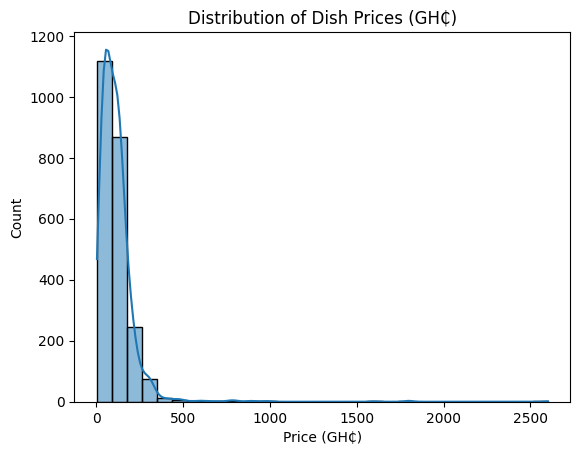

In [163]:
# Convert price to numeric
combined_df['price'] = pd.to_numeric(combined_df['price'], errors='coerce')

# Now drop rows where price is NaN
price_df = combined_df.dropna(subset=['price'])

# Plot again
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(price_df['price'], bins=30, kde=True)
plt.title("Distribution of Dish Prices (GH₵)")
plt.xlabel("Price (GH₵)")
plt.show()

In [164]:
print("Average price GH₵:", price_df['price'].mean())
print("Median price GH₵:", price_df['price'].median())
print("Cheapest meal GH₵:", price_df['price'].min())
print("Most expensive meal GH₵:", price_df['price'].max())

Average price GH₵: 114.13701881950384
Median price GH₵: 96.0
Cheapest meal GH₵: 4.0
Most expensive meal GH₵: 2600.0


C:\Users\Jedda\AppData\Local\Temp\ipykernel_34140\2591535153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['taste'] = pd.to_numeric(price_df['taste'], errors='coerce')


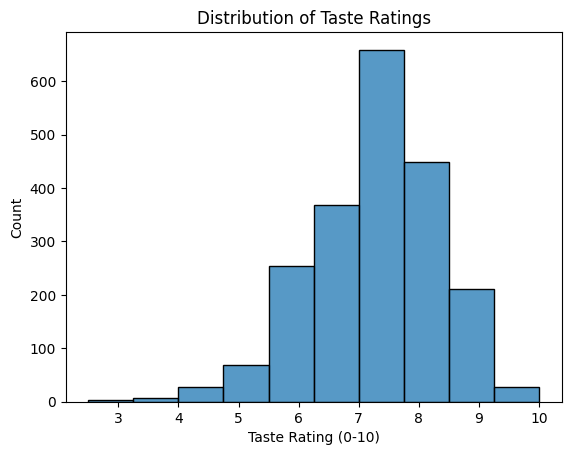

In [165]:
# Make taste numeric for plotting
price_df['taste'] = pd.to_numeric(price_df['taste'], errors='coerce')

sns.histplot(price_df['taste'].dropna(), bins=10, kde=False)
plt.title("Distribution of Taste Ratings")
plt.xlabel("Taste Rating (0-10)")
plt.ylabel("Count")
plt.show()

portion_size
small                               6.636364
Small                              15.666667
Medium                             25.500000
Drinks                             30.357143
medium                             31.172414
large                              32.285714
Soft Drinks                        36.714286
1L                                 45.000000
 Medium                            45.000000
medium+                            50.000000
Tandoori ( Naan)                   50.615385
Cocktails                          56.666667
Yoghurt                            59.400000
HI! Tea                            60.000000
Salad                              68.750000
Alcoholic                          76.733333
Quarter                            80.000000
Desserts                           83.333333
Vegeterian Chat                    85.500000
Chef Special Soup                  88.333333
Large                             102.875000
Weekend Menu                      103.0000

C:\Users\Jedda\AppData\Local\Temp\ipykernel_34140\2804551759.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=portion_avg.index, y=portion_avg.values, palette="Set2")


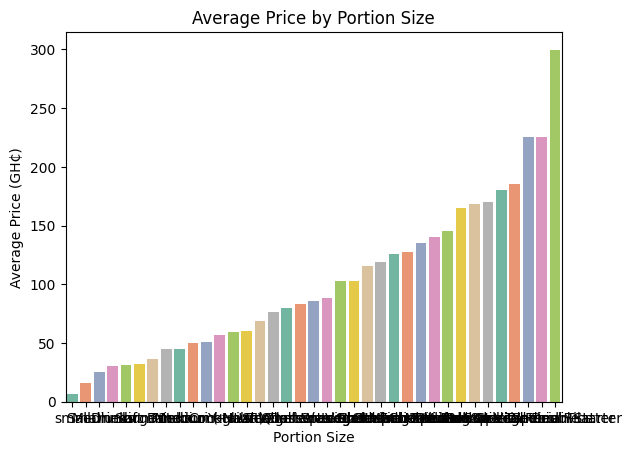

In [166]:
portion_avg = price_df.groupby('portion_size')['price'].mean().sort_values()
print(portion_avg)

sns.barplot(x=portion_avg.index, y=portion_avg.values, palette="Set2")
plt.title("Average Price by Portion Size")
plt.xlabel("Portion Size")
plt.ylabel("Average Price (GH₵)")
plt.show()

In [167]:
from sklearn.preprocessing import MinMaxScaler

df = price_df.copy()

# scale price (lower → better) and taste (higher → better)
scaler = MinMaxScaler()
df['price_norm'] = 1 - scaler.fit_transform(df[['price']])  # cheaper = higher score
df['taste_norm'] = scaler.fit_transform(df[['taste']].fillna(0))

# combined value-for-money score
df['value_score'] = 0.5*df['taste_norm'] + 0.5*df['price_norm']

df[['restaurant','food','price','taste','value_score']].sort_values('value_score', ascending=False).head(10)

,restaurant,food,price,taste,value_score
114,Pizzaman Chickenman,Bottle Water,5.5,10.0,0.999711
2214,Jama y)),Beans,10.0,10.0,0.998844
211,Pizza Hut,Voltic Water 500 Ml.,8.0,9.8,0.989230
2217,Didi,Jollof,65.0,10.0,0.988251
410,Cups and Cones,water,5.0,9.7,0.984807
525,Delibeli Restaurant and Bar,Water,10.0,9.6,0.978844
438,Jollof Express by Yes Chef,Bottle Water,5.0,9.5,0.974807
1306,Yehowada,BelAqua,10.0,9.5,0.973844
1692,Chickie’s Restaurant,Water,10.0,9.5,0.973844
1067,Ninano Restaurant Osu,Water,10.0,9.4,0.968844


In [168]:
def recommend_dish(dish_name, df, top_k=5, cheap_bias=0.5):
    """
    dish_name: string search term (e.g., "Waakye")
    df: dataset with normalized values
    top_k: number of results
    cheap_bias: weight given to cheapness vs taste [0..1]
                1.0 = only price matters
                0.0 = only taste matters
    """
    
    # Filter rows where food name contains the dish
    subset = df[df['food'].str.contains(dish_name, case=False, na=False)].copy()
    
    if subset.empty:
        return f"No matches found for {dish_name}"
    
    # Score function: weighted average
    subset['score'] = cheap_bias*subset['price_norm'] + (1 - cheap_bias)*subset['taste_norm']
    
    return subset.sort_values('score', ascending=False).head(top_k)[
        ['restaurant','food','price','taste','location','portion_size','dish_category','score']
    ]

# Example Usage:
print(recommend_dish("Waakye", df, top_k=5, cheap_bias=0.7))
print(recommend_dish("Jollof", df, top_k=3, cheap_bias=0.3))

                     restaurant  \
345                    Faridish   
353              Dowu’s Kitchen   
1407                 Awo Aduane   
2235                 Sweet Lami   
1013  The Gold Coast Restaurant   

                                                   food  price  taste  \
345                                              Waakye   10.0    8.1   
353                         Waakye with Protein & Salad   50.0    7.8   
1407                                             Waakye   80.0    7.0   
2235                                             Waakye   15.0    6.4   
1013  Waakye premium with Beef or Fish Stew and plan...  120.0    7.3   

          location portion_size                dish_category     score  
345          Accra          NaN                        Mains  0.941382  
353          Accra          NaN  Traditional Ghanaian Dishes  0.921596  
1407         Accra          NaN                 Rice Dishes   0.889507  
2235  Night Market       medium                Uncategoriz

In [169]:
import sys
print(sys.executable)


c:\Users\Jedda\AppData\Local\Programs\Python\Python312\python.exe


In [170]:
!C:\Users\Jedda\AppData\Local\Programs\Python\Python312\python.exe -m pip install rapidfuzz


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [171]:
import rapidfuzz
print("RapidFuzz version:", rapidfuzz.__version__)

RapidFuzz version: 3.14.1


In [172]:

from rapidfuzz import process

def recommend_dish_fuzzy(dish_name, df, top_k=5, cheap_bias=0.5, cutoff=70):
    """
    dish_name  : Query string (e.g., 'waaky3')
    df         : DataFrame with normalized price/taste
    top_k      : How many options to return
    cheap_bias : 1.0 = prioritize cheap, 0.0 = prioritize taste
    cutoff     : Minimum fuzzy string similarity (0–100)
    """
    # Get all unique dishes
    unique_dishes = df['food'].dropna().unique().tolist()
    
    # Try to find the closest fuzzy match
    result = process.extractOne(dish_name, unique_dishes, score_cutoff=cutoff)
    
    if result is None:
        return f"No matches found for '{dish_name}'"
    
    match, similarity = result
    print(f"🔎 Input '{dish_name}' matched to '{match}' (similarity {similarity})")
    
    # Filter by the chosen match
    subset = df[df['food'].str.contains(match, case=False, na=False)].copy()
    
    if subset.empty:
        return f"No rows found matching '{match}' in dataset"
    
    # Weighted score: price vs taste
    subset.loc[:, 'score'] = cheap_bias*subset['price_norm'] + (1 - cheap_bias)*subset['taste_norm']
    
    return subset.sort_values('score', ascending=False).head(top_k)[
        ['restaurant', 'food', 'price', 'taste', 'location', 
         'portion_size', 'dish_category', 'score']
    ]
